In [577]:
import random

#param = [0="weak", 1="strong"]

class User():
    def __init__(self, data_ratio=0.2, param_ratio=0.5):
        data = [0,1]
        param = [0,1]
        
        temp_data = random.choices(data, weights=[1-data_ratio, data_ratio])[0]
        self.param = random.choices(param, weights=[1-param_ratio, param_ratio])[0]
        self.data = Data(temp_data)
        
        self.mec = Mechanism(self.param)
        
    def send(self):
        temp_data = self.mec.perturb(self.data.data)
        return Data(temp_data, is_perturbed=True, orig_data=self.data.data, param=self.param)
        s
class Mechanism():
    def __init__(self, param=0):
        self.data = [0,1]
        
        def probability(param):
            if param == 0:
                return np.array([[0.8,0.2],[0.2,0.8]])
            else:
                return np.array([[0.6,0.4],[0.4,0.6]])
            
        self.distribution = probability(param)
    
    def perturb(self, data):
        distribution = self.distribution[data]
        return random.choices(self.data, distribution)[0]
    
    
class Data():
    def __init__(self, data=0 ,is_perturbed=False, orig_data=None, param=None):
        self.data = data
        
        if is_perturbed:
            self.orig_data = orig_data
            self.param = param

In [578]:
import numpy as np

#data_ratio = 0.1
#param_ratio = 0.5

#p_bb = (1-param_ratio) * Mechanism(0).distribution[0][0] + param_ratio * Mechanism(1).distribution[0][0]
def est_pi(obs, p_bb):
    return (p_bb - 1)/(2 * p_bb - 1) + obs/(2 * p_bb - 1)
def var_pi(obs, univ, p_bb):
    pi = est_pi(obs, p_bb)
    return pi*(1-pi)/(univ-1) + (1/(16*((p_bb - 0.5) ** 2)) - (1/4))/(univ-1)
def analyze(collected_data):
    
    univ = len(collected_data)
    
    data_from_param0 = [data for data in collected_data if data.param == 0]
    data_from_param1 = [data for data in collected_data if data.param == 1]
    
    param_ratio = len(data_from_param1)/(len(data_from_param0) + len(data_from_param1))
    
    obs = np.sum([data.data for data in collected_data])/univ
    
    p_bb = (1-param_ratio) * Mechanism(0).distribution[0][0] + param_ratio * Mechanism(1).distribution[0][0]
    
    #print("est", est_pi(obs, p_bb))
    #print("std", np.sqrt(var_pi(obs, univ, p_bb)))
    
    return est_pi(obs, p_bb)
    
def collect(data_ratio, param_ratio, num_univ=1000):
    collected_data = []
    for _ in range(num_univ):
        user = User(data_ratio=data_ratio, param_ratio=param_ratio)
        collected_data.append(user.send())
    return collected_data

In [579]:
def k_0(data, secret=False, param_ratio=None):
    if not secret:
        return 2 * Mechanism(data.param).distribution[1][data.data] - 1
    else:
        return 2 * (param_ratio * Mechanism(param=0).distribution[1][data.data] + (1-param_ratio) * Mechanism(param=1).distribution[1][data.data]) - 1                
def k_1(data, secret=False, param_ratio=None):
    if not secret:
        return Mechanism(data.param).distribution[1][data.data] - 1
    else:
        return param_ratio * Mechanism(param=0).distribution[1][data.data] + (1-param_ratio) * Mechanism(param=1).distribution[1][data.data] - 1

def likelyhood(collected_data):
    def likelyhood(ratio):
        result = 0
        for data in collected_data:
            result += np.log(ratio * k_0(data) - k_1(data))
        return result
    return likelyhood

In [580]:
def cp_coef(data):
    other_data = make_other_data(data)
    
    term3 = k_0(data)
    for data_ in other_data:
        term3 *= k_0(data_)
    
    term2 = 0
    for data_ in other_data:
        other_data_ = make_other_data(data_)
        term2 -= k_1(data_)*np.prod([k_0(data__) for data__ in other_data_])
        
    term1 = 0
    for data_ in other_data:
        ohter_data_ = make_other_data(data_)
        term1 += k_0(data) * k_0(data_)*np.prod([k_1(data__) for data__ in other_data_]) / k_1(data)
    #term1 *= k_0(data) / k_1(data)
    
    term0 = -k_0(data)
    for data_ in other_data:
        term0 *= k_1(data_)
    
    return np.array([term3, term2, term1, term0])

In [581]:
def make_other_data(in_data):
    param = in_data.param
    data = in_data.data
    
    inv_param = int(not param)
    inv_data = int(not data)
    
    data0 = Data(data=data, is_perturbed=True, param=inv_param)
    data1 = Data(data=inv_data, is_perturbed=True, param=inv_param)
    data2 = Data(data=inv_data, is_perturbed=True, param=param)
    
    return [data0, data1, data2]

In [582]:
from sympy import solve
from sympy import re
from sympy import Symbol
def max_likelyhood(collected_data, secret=False):
    z_0w = Data(data=0, is_perturbed=True, param=0)
    z_1w = Data(data=1, is_perturbed=True, param=0)
    z_0s = Data(data=0, is_perturbed=True, param=1)
    z_1s = Data(data=1, is_perturbed=True, param=1)
    
    data_from_param0_and_z0 = [data for data in collected_data if data.param == 0 and data.data == 0]
    data_from_param1_and_z0 = [data for data in collected_data if data.param == 1 and data.data == 0]
    data_from_param0_and_z1 = [data for data in collected_data if data.param == 0 and data.data == 1]
    data_from_param1_and_z1 = [data for data in collected_data if data.param == 1 and data.data == 1]
    
    data_from_param0 = [data for data in collected_data if data.param == 0]
    data_from_param1 = [data for data in collected_data if data.param == 1]
    param_ratio = len(data_from_param1)/(len(data_from_param0) + len(data_from_param1))
    
    coef = len(data_from_param0_and_z0) * cp_coef(z_0w) + len(data_from_param1_and_z0) * cp_coef(z_0s)\
            + len(data_from_param0_and_z1) * cp_coef(z_1w) + len(data_from_param1_and_z1) * cp_coef(z_1s)
    
    x=Symbol('x')
    
    def temp(data, x):
        other_data = make_other_data(data)
        res = k_0(data)
        for data_ in other_data:
            res *= (x * k_0(data_) - k_1(data_))
        return res
        
    if not secret:

        sol = solve(len(data_from_param0_and_z0) * temp(z_0w, x) + len(data_from_param1_and_z0) * (temp(z_0s, x))\
                   + len(data_from_param0_and_z1) * temp(z_1w, x) + len(data_from_param1_and_z1) * temp(z_1s, x))
        #sol=solve(coef[0] * (x **3) + coef[1] * (x **2) + coef[2] * x + coef[3], x)
        return sol[1]
    else:
        return ((len(data_from_param0_and_z0) + len(data_from_param1_and_z0)) * k_0(z_0w, secret=True, param_ratio=param_ratio)*k_1(z_1w, secret=True, param_ratio=param_ratio)\
        + (len(data_from_param0_and_z1) + len(data_from_param1_and_z1)) * k_0(z_1w, secret=True, param_ratio=param_ratio)*k_1(z_0w, secret=True, param_ratio=param_ratio))\
        / (len(collected_data) * k_0(z_0w, secret=True, param_ratio=param_ratio) * k_0(z_1w, secret=True, param_ratio=param_ratio))
    

In [583]:
def cp_ref(collected_data):
    data_from_0 = [data for data in collected_data if data.orig_data == 0]
    data_from_1 = [data for data in collected_data if data.orig_data == 1]
    return len(data_from_1) / (len(data_from_0) + len(data_from_1))

def accumurate(data_ratio, param_ratio, n_iter=1000, secret=False, is_likelyhood=True, num_univ=1000):
    solved = []
    ref = []
    for _ in range(n_iter):
        collected_data = collect(data_ratio=data_ratio, param_ratio=param_ratio, num_univ=num_univ)
        if is_likelyhood:
            solved.append(np.float(re(max_likelyhood(collected_data, secret=secret))))
        else:
            if secret:
                solved.append(analyze(collected_data))
            else:
                data_from_param0 = [data for data in collected_data if data.param == 0]
                data_from_param1 = [data for data in collected_data if data.param == 1]
                a = analyze(collected_data)
                b = analyze(data_from_param0)
                c = analyze(data_from_param1)
                solved.append((a,b,c))
        ref.append(cp_ref(collected_data))
        
    if isinstance(solved[0], tuple):
        temps = []
        for i in range(len(solved[0])):
            temps.append(analyze_error([temp[i] for temp in solved], ref, verbose=False)[0])
        argmax = np.argmin(temps)
        solved = [temp[argmax] for temp in solved]
        print(f"choose index {argmax}")
        
    return solved, ref

def analyze_error(solved, ref, verbose=True):
    if verbose:
        print(f"estimation: {np.mean([temp for temp in solved])}")
    errors = []
    for solved_, ref_ in zip(solved, ref):
        errors.append(np.sqrt((solved_ - ref_) **2))
    return np.average(errors), np.std(errors)

#### 4通り
- 尤度推定
    - 秘匿パラメータ=True
    - 秘匿パラメータ=False
- 近似
    - 秘匿パラメータ=True
    
比較は秘匿パラメータの最高 vs 公開パラメータの最高

とりあえず最初は三種類で比較すれば良い

色々なデータの分布で試す

In [584]:
def results(data_ratios, secret, n_univ, n_iter):
    results = {data_ratio:0 for data_ratio in data_ratios}
    for data_ratio in data_ratios:
        print(f"data_ratio:{data_ratio}")
        if secret:
            print("secret")
            likely = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=True, is_likelyhood=True, num_univ=n_univ))
            appro = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=True, is_likelyhood=False, num_univ=n_univ))
        else:
            print("public")
            likely = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=False, is_likelyhood=True, num_univ=n_univ))
            appro = analyze_error(*accumurate(data_ratio=data_ratio, param_ratio=0.5, n_iter=n_iter, secret=False, is_likelyhood=False, num_univ=n_univ))
        results[data_ratio] = [likely, appro]
    return results

In [ ]:
n_univ = 10000
n_iter = 10000
data_ratios = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
results_secret = results(data_ratios, secret=True, n_univ=n_univ, n_iter=n_iter)
#results_public = results(data_ratios, secret=False, n_univ=n_univ, n_iter=n_iter)

data_ratio:0
secret
estimation: -1.1379304234462956e-05
estimation: 5.362818267676688e-05
data_ratio:0.1
secret
estimation: 0.0996494334186329
estimation: 0.09989963386713949
data_ratio:0.2
secret
estimation: 0.20018325551412902
estimation: 0.20003385299160442
data_ratio:0.3
secret
estimation: 0.3002402369487796
estimation: 0.2998594052040887
data_ratio:0.4
secret


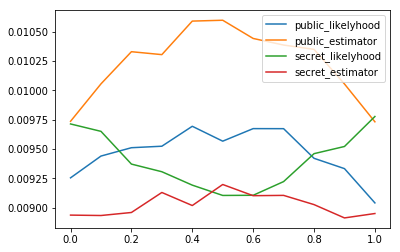

In [593]:
import matplotlib.pyplot as plt
plt.plot(data_ratios, [result[0][0] for _, result in results_public.items()], label="public_likelyhood")
plt.plot(data_ratios, [result[1][0] for _, result in results_public.items()], label="public_estimator")
plt.plot(data_ratios, [result[0][0] for _, result in results_secret.items()], label="secret_likelyhood")
plt.plot(data_ratios, [result[1][0] for _, result in results_secret.items()], label="secret_estimator")
plt.legend()
#plt.savefig(f"results/univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.eps")

In [5]:
import matplotlib.pyplot as plt
plt.plot(data_ratios, [result[0][0] for _, result in results_public.items()], label="公開_最尤推定")
plt.plot(data_ratios, [result[1][0] for _, result in results_public.items()], label="公開_推定量")
plt.plot(data_ratios, [result[0][0] for _, result in results_secret.items()], label="秘匿_最尤推定")
plt.plot(data_ratios, [result[1][0] for _, result in results_secret.items()], label="秘匿_推定量")
plt.legend(fontsize=12)
plt.xlabel("データ頻度", fontsize=15)
plt.ylabel("推定値の誤差の標準偏差", fontsize=15)


#plt.savefig(f"results/univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.eps",bbox_inches="tight", pad_inches=0.0)

NameError: name 'data_ratios' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


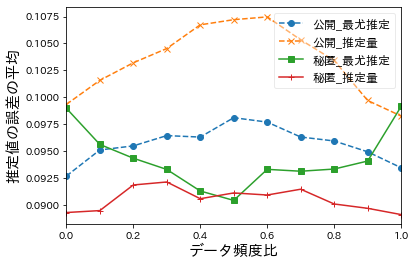

In [8]:
import matplotlib.pyplot as plt
import japanize_matplotlib
param_ratios = list(results_public.keys())
plt.plot(param_ratios, [result[0][0] for _, result in results_public.items()], linestyle="dashed", marker="o", label="公開_最尤推定")
plt.plot(param_ratios, [result[1][0] for _, result in results_public.items()], linestyle="dashed", marker="x", label="公開_推定量")
plt.plot(param_ratios, [result[0][0] for _, result in results_secret.items()], marker="s", label="秘匿_最尤推定")
plt.plot(param_ratios, [result[1][0] for _, result in results_secret.items()], marker="+", label="秘匿_推定量")
plt.legend(fontsize=12, framealpha=0.4)
plt.xlabel("データ頻度比", fontsize=15)
plt.ylabel("推定値の誤差の平均", fontsize=15)
plt.xlim(0,1)


plt.savefig(f"univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.eps",bbox_inches="tight", pad_inches=0.0)



In [9]:
param_ratios

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [7]:
import pickle
n_univ = 100
n_iter = 10000
param_ratio = 0.5
#with open(f"data/univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.pkl", "wb") as f:
#    pickle.dump([results_public, results_secret], f)
with open(f"data/univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.pkl", "rb") as f:
    results_public, results_secret = pickle.load(f)

In [628]:
n_univ = 10000
param_ratio = 0.5
n_iter = 10000
with open(f"data/univ_{n_univ}_param_{param_ratio}_n_iter_{n_iter}.pkl", "rb") as f:
    results_public, results_secret = pickle.load(f)

In [10]:
print("a")

a


In [553]:
results_secret

{0: [(0.0989809988225292, 0.07450987197755014),
  (0.08928905365886602, 0.06823705406124517)],
 0.1: [(0.09561844949652877, 0.07282671019500295),
  (0.08946908783837866, 0.06843109284085214)],
 0.2: [(0.09433729221187864, 0.070978101566193),
  (0.09184980059503497, 0.06914386657045406)],
 0.3: [(0.09329275453107506, 0.07005702709706442),
  (0.09212790536829918, 0.06887127220364485)],
 0.4: [(0.09128955446748266, 0.07007666593722103),
  (0.09057340249970676, 0.06941868092334587)],
 0.5: [(0.09041675208768134, 0.0693935726870455),
  (0.09111056075789889, 0.0692571067288501)],
 0.6: [(0.09330187029973548, 0.07032393132902444),
  (0.09091700533287815, 0.06854679147611792)],
 0.7: [(0.0931271385514471, 0.0701892793293362),
  (0.09145544394068691, 0.06961281120790384)],
 0.8: [(0.09332981947428186, 0.07090086124095778),
  (0.09008370966607993, 0.06878879398243988)],
 0.9: [(0.09407348369754234, 0.07136386002694123),
  (0.08968046964763018, 0.06704416768026755)],
 1: [(0.0991450658863115, 0.0

In [6]:
import japanize_matplotlib